# Learning Laplacian eigenfunctions in two dimensions

In [1]:
# Load libraries
import logging

import matplotlib.pyplot as plt
import numpy as np

from klap import (
    ExponentialKernel,
    GaussianKernel,
    PolynomialKernel,
)
from klap.datasets import (
    concentric_circle,
    halfmoons,
)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{mathtools}")
plt.rc("font", size=10, family="serif", serif="cm")
plt.rc("figure", figsize=(2, 1.5))

# Set logger
logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s %(levelname)s %(message)s",
)

#### Generate data 

In [2]:
np.random.seed(100)
n = 100000
p = 1000

# # Learn halfmoons
# x = halfmoons(n, noise_level=.1)
# X, Y = np.meshgrid(np.linspace(-1.5, 1.5, num=500), np.linspace(-1.5, 2.5, num=500))

# # Concentric circles
# x = concentric_circle(n, noise_level=0)
# X, Y = np.meshgrid(np.linspace(-4.5, 4.5, num=500), np.linspace(-4.5, 4.5, num=500))

# Learn Hermite
x = np.random.randn(n, 2) * .1
X, Y = np.meshgrid(np.linspace(-1, 1, num=500), np.linspace(-1, 1, num=500))

# # Learn Chebychev
# x = np.random.rand(n, 2)
# X, Y = np.meshgrid(np.linspace(0, 1, num=500), np.linspace(0, 1, num=500))

#### Choose a kernel and a method

In [3]:
kernel = PolynomialKernel(d=3)
# kernel = ExponentialKernel(sigma=10)
# kernel = ExponentialKernel(sigma=1)
# kernel = GaussianKernel(sigma=.3)

graph_laplacian = False

#### Fit eigenfunctions

In [4]:
help(kernel.fit)

Help on method fit in module klap.kernels.kernel_laplacian:

fit(x, p=None, k=None, L_reg: float = 0, R_reg: float = 0, inverse_L: bool = False) method of klap.kernels.polynomial.PolynomialKernel instance
    Estimate Laplacian operator based on data.
    
    Parameters
    ----------
    x: ndarray of size (n, d)
        Data matrix
    p: int (optional, default is None)
        Number of representer points to use
    k: int (optional, default is None)
        Number of eigenvalues to compute. If None, k will be taken as self.k (default is 16)
    L_reg: float (optional, default is 0)
        Regularization parameter for Laplacian matrix
    R_reg: float (optional, default is 0)
        Regularization parameter for Nystrom matrix
    inverse_L: bool (optional, default is False)
        Either to inverse L or R in the GEVD system.



In [5]:
k = 16
L_reg = 1e-6
R_reg = 0
inverse_L = False

if graph_laplacian:
    weigth_kernel = GaussianKernel(sigma=.1).kernel
    kernel.fit_with_graph_laplacian(weigth_kernel, x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)
else:
    kernel.fit(x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)

2023-05-05 20:00:05,409 INFO Dot product kernel computation
2023-05-05 20:00:14,231 INFO Inversing R
2023-05-05 20:00:14,412 INFO Matrix is not sdp.
2023-05-05 20:00:14,415 INFO Setting regularizer to 3.399e-13


#### Get eigenfunctions / features map

In [6]:
x_test = np.stack((X.flatten(), Y.flatten()), axis=-1)
phi = kernel(x_test)

#### Plot eigenfunctions

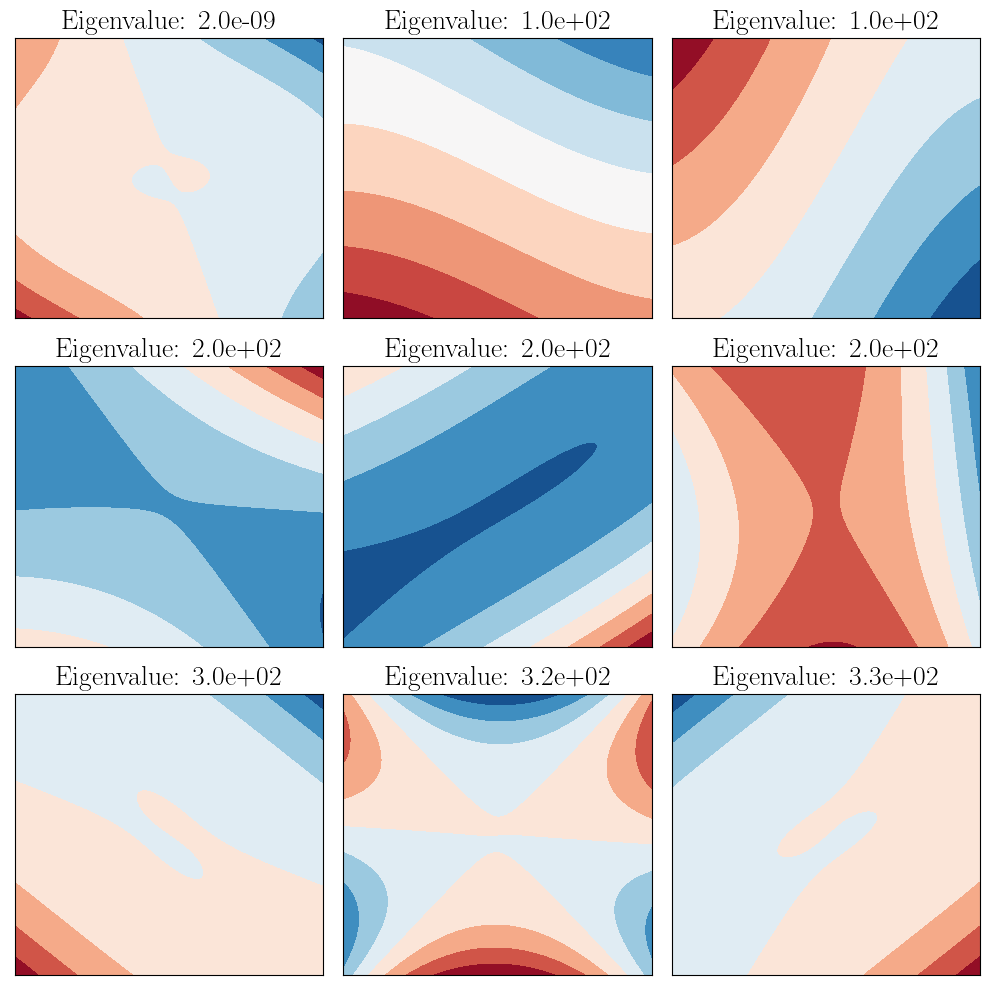

In [7]:
num = 3
fig, axes = plt.subplots(num, num, figsize=(10, 10))
for i in range(num ** 2):
    axes[i//num, i%num].contourf(X, Y, phi[:, i].reshape(*X.shape), cmap='RdBu_r')
    axes[i//num, i%num].scatter(x[:, 0], x[:, 1], alpha=.001, s=10, c='k')
    axes[i//num, i%num].tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
    axes[i//num, i%num].set_xticks([])
    axes[i//num, i%num].set_yticks([])
    axes[i//num, i%num].set_title(f"Eigenvalue: {kernel.eigenvalues[i]:.1e}", fontsize=20)
    axes[i//num, i%num].set_xlim(-1, 1)
    axes[i//num, i%num].set_ylim(-1, 1)
fig.tight_layout()
fig.savefig("hermite_2d.jpg", bbox_inches="tight")

## Ground Truth for Hermite polynomials

In [8]:
def hermite(x, y, n, m):
    out = np.zeros_like(x)
    for k in range(min(n, m) + 1):
        out += (-1) ** k * np.math.factorial(n) * np.math.factorial(m) * x ** (n - k) * y ** (m - k) / (
                np.math.factorial(k) * np.math.factorial(n - k) * np.math.factorial(m - k))
    return out

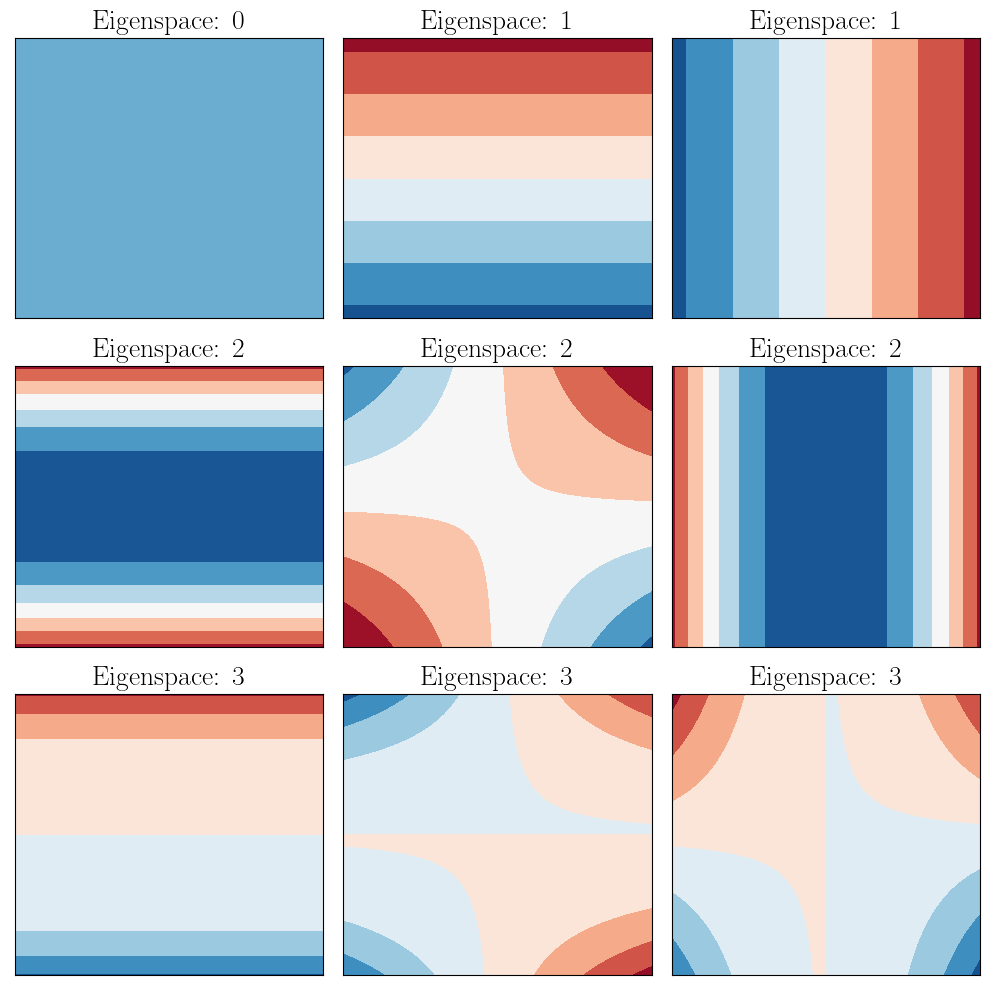

In [12]:
lim = 5
X_, Y_ = np.meshgrid(np.linspace(-lim, lim, num=500), np.linspace(-lim, lim, num=500))
fig, axes = plt.subplots(num, num, figsize=(10, 10))
i = 0
for sum_nm in range(6):
    for j in range(sum_nm + 1):
        n = j
        m = sum_nm - j

        phi_i = hermite(X_.flatten(), Y_.flatten(), n, m)
        axes[i//num, i%num].contourf(X_, Y_, phi_i.reshape(*X.shape), cmap='RdBu_r')
        axes[i//num, i%num].tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
        axes[i//num, i%num].set_xticks([])
        axes[i//num, i%num].set_yticks([])
        axes[i//num, i%num].set_title(f"Eigenspace: {sum_nm}", fontsize=20)
        axes[i//num, i%num].set_xlim(-lim, lim)
        axes[i//num, i%num].set_ylim(-lim, lim)
        i += 1

        if i == num ** 2:
            break
    if i == num ** 2:
        break
fig.tight_layout()
fig.savefig("true_hermite_2d.jpg", bbox_inches="tight")